In [35]:
# Dependency installs
%pip install vitaldb
%pip install torch
%pip install numpy
%pip install pandas


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import vitaldb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

Case Selection

In [36]:
# inclusion & exclusion criteria
'''
caseids = list(
    set(df_trks[df_trks['tname'] == 'SNUADC/ART']['caseid']) &
    set(df_cases[df_cases['age'] > 18]['caseid']) &
    set(df_cases[df_cases['age'] >= 18]['caseid']) & 
    set(df_cases[df_cases['weight'] >= 30]['caseid']) & 
    set(df_cases[df_cases['weight'] < 140]['caseid']) & 
    set(df_cases[df_cases['height'] >= 135]['caseid']) & 
    set(df_cases[df_cases['height'] < 200]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("transplant", case=False)]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aneurysm", case=False)]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aorto", case=False)]['caseid'])& 
    set(df_cases[df_cases['ane_type'] == 'General']['caseid'])
)
'''

caseids = list(
    set(df_trks.loc[df_trks['tname'] == 'SNUADC/ART', 'caseid']) & 
    set(df_trks.loc[df_trks['tname'] == 'SNUADC/ECG_II', 'caseid']) & 
    set(df_trks.loc[df_trks['tname'] == 'BIS/EEG1_WAV', 'caseid']) & 
    set(df_cases.loc[df_cases['age'] > 18, 'caseid']) & 
    set(df_cases.loc[df_cases['ane_type'] == 'General', 'caseid'])
)
print(f'{len(caseids)} cases found')

print('Total {} cases found'.format(len(caseids)))
np.random.shuffle(caseids)  # shuffle caseids

3295 cases found
Total 3295 cases found


Preprocessing

In [4]:
MINUTES_AHEAD = 1  # Predict hypotension 1 minutes ahead
BATCH_SIZE = 256  # Batch size for learning
MAX_CASES = 100  # Maximum number of cases for this example
SRATE = 100  # sampling rate for the arterial waveform signal

# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the arterial waveform
    arts = vitaldb.load_case(caseid, ['SNUADC/ART'], 1 / SRATE).flatten()

    case_sample = 0
    case_event = 0
    for i in range(0, len(arts) - SRATE * (20 + (1 + MINUTES_AHEAD) * 60), 10 * SRATE):
        segx = arts[i:i + SRATE * 20]
        segy = arts[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (MINUTES_AHEAD + 1) * 60)]

        # check the validity of this segment
        valid = True
        if np.isnan(segx).mean() > 0.1:
            valid = False
        elif np.isnan(segy).mean() > 0.1:
            valid = False
        elif (segx > 200).any():
            valid = False
        elif (segy > 200).any():
            valid = False
        elif (segx < 30).any():
            valid = False
        elif (segy < 30).any():
            valid = False
        elif np.max(segx) - np.min(segx) < 30:
            valid = False
        elif np.max(segy) - np.min(segy) < 30:
            valid = False
        elif (np.abs(np.diff(segx)) > 30).any():  # abrupt change -> noise
            valid = False
        elif (np.abs(np.diff(segy)) > 30).any():  # abrupt change -> noise
            valid = False

        # 2 sec moving avg
        n = 2 * SRATE  
        segy = np.nancumsum(segy, dtype=np.float32)
        segy[n:] = segy[n:] - segy[:-n]
        segy = segy[n - 1:] / n

        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        valid_mask.append(valid)
        c.append(caseid)
        
        if valid:
            case_sample += 1
            if evt:
                case_event += 1

    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100 * case_event / case_sample))
    else:
        print('no sample')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

# convert lists to numpy array
x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

# normalization
x -= 65
x /= 65

# add axis for CNN
x = x[...,None]  

print(x.shape)
print(y.shape)

loading 1950...935 samples 0 (0.0 %) events
loading 2888...896 samples 0 (0.0 %) events
loading 3440...589 samples 22 (3.7 %) events
loading 1500...836 samples 0 (0.0 %) events
loading 4686...727 samples 10 (1.4 %) events
loading 4929...525 samples 14 (2.7 %) events
loading 3150...1623 samples 0 (0.0 %) events
loading 1942...415 samples 0 (0.0 %) events
loading 3112...1375 samples 0 (0.0 %) events
loading 5321...1617 samples 59 (3.6 %) events
loading 4632...1397 samples 1 (0.1 %) events
loading 1468...1871 samples 3 (0.2 %) events
loading 3703...898 samples 0 (0.0 %) events
loading 2203...no sample
loading 818...2821 samples 645 (22.9 %) events
loading 304...1142 samples 19 (1.7 %) events
loading 3409...1091 samples 0 (0.0 %) events
loading 2479...251 samples 0 (0.0 %) events
loading 5108...1548 samples 22 (1.4 %) events
loading 478...462 samples 7 (1.5 %) events
loading 4150...1037 samples 13 (1.3 %) events
loading 3200...586 samples 0 (0.0 %) events
loading 4457...1192 samples 0 (0.0

C:\Users\aaron\AppData\Local\Temp\ipykernel_34280\2623668723.py:83: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values


(135995, 2000, 1)
(135995,)


Splitting samples into training and testing dataset

In [37]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# splitting into train set and test set
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

train_x = x[train_mask]
train_y = y[train_mask]
test_x = x[test_mask]
test_y = y[test_mask]

train_x_valid = x[train_mask & valid_mask]
train_y_valid = y[train_mask & valid_mask]
test_x_valid = x[test_mask & valid_mask]
test_y_valid = y[test_mask & valid_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), \
    len(train_y_valid), sum(train_y_valid), 100 * np.mean(train_y_valid), \
    len(test_y_valid), sum(test_y_valid), 100 * np.mean(test_y_valid))
print(testname)

100cases 1ahead batchsize=256 total 135995, train 74445 (2154 events 2.9%), test 25438 (1365 events 5.4%)


Model building and training (PyTorch)

In [49]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import random
from torch.utils.data import TensorDataset
from tqdm import tqdm

'''
Supplementable Table S1 from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0272055 dictates the hyperparameters used
'''

class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, size_down: bool = False) -> None:
        super(ResidualBlock, self).__init__()
        
        self.size_down = size_down
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        
        # unclear where in sequence this hsuold take place. Size down expressed in Supplemental table S1
        if self.size_down:
            self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        out = self.bn1(x)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)
        out += identity
        if self.size_down:
            out = self.pool(out)
        
        '''out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out += identity
        if self.size_down:
            out = self.pool(out)'''

        return  out

class HypotensionCNN(nn.Module):
    def __init__(self, useAbp: bool = True, useEeg: bool = False, useEcg: bool = False) -> None:
        super(HypotensionCNN, self).__init__()

        self.useAbp = useAbp
        self.useEeg = useEeg
        self.useEcg = useEcg

        if useAbp:
            self.abpBlock1 = ResidualBlock(1, 2, 7, 1, True)
            self.abpBlock2 = ResidualBlock(2, 2, 7, 1, False)
            self.abpBlock3 = ResidualBlock(2, 2, 7, 1, True)
            self.abpBlock4 = ResidualBlock(2, 2, 7, 1, False)
            self.abpBlock5 = ResidualBlock(2, 2, 7, 1, True)
            self.abpBlock6 = ResidualBlock(2, 4, 7, 1, False)
            self.abpBlock7 = ResidualBlock(2, 4, 3, 1, True)
            self.abpBlock8 = ResidualBlock(4, 4, 3, 1, False)
            self.abpBlock9 = ResidualBlock(4, 4, 3, 1, True)
            self.abpBlock10 = ResidualBlock(4, 4, 3, 1, False)
            self.abpBlock11 = ResidualBlock(4, 6, 3, 1, True)
            self.abpBlock12 = ResidualBlock(6, 6, 3, 1, False)
            self.abpFc = nn.Linear(6 * 120, 32)
        
        if useEcg:
            self.ecgBlock1 = ResidualBlock(1, 2, 7, 1, True)
            self.ecgBlock2 = ResidualBlock(2, 2, 7, 1, False)
            self.ecgBlock3 = ResidualBlock(2, 2, 7, 1, True)
            self.ecgBlock4 = ResidualBlock(2, 2, 7, 1, False)
            self.ecgBlock5 = ResidualBlock(2, 2, 7, 1, True)
            self.ecgBlock6 = ResidualBlock(2, 4, 7, 1, False)
            self.ecgBlock7 = ResidualBlock(2, 4, 3, 1, True)
            self.ecgBlock8 = ResidualBlock(4, 4, 3, 1, False)
            self.ecgBlock9 = ResidualBlock(4, 4, 3, 1, True)
            self.ecgBlock10 = ResidualBlock(4, 4, 3, 1, False)
            self.ecgBlock11 = ResidualBlock(4, 6, 3, 1, True)
            self.ecgBlock12 = ResidualBlock(6, 6, 3, 1, False)
            self.ecgFc = nn.Linear(6 * 496, 32)
        
        if useEeg:
            self.eegBlock1 = ResidualBlock(1, 2, 15, 1, True)
            self.eegBlock2 = ResidualBlock(2, 2, 15, 1, False)
            self.eegBlock3 = ResidualBlock(2, 2, 15, 1, True)
            self.eegBlock4 = ResidualBlock(2, 2, 15, 1, False)
            self.eegBlock5 = ResidualBlock(2, 2, 15, 1, True)
            self.eegBlock6 = ResidualBlock(2, 4, 15, 1, False)
            self.eegBlock7 = ResidualBlock(2, 4, 7, 1, True)
            self.eegBlock8 = ResidualBlock(4, 4, 7, 1, False)
            self.eegBlock9 = ResidualBlock(4, 4, 7, 1, True)
            self.eegBlock10 = ResidualBlock(4, 4, 7, 1, False)
            self.eegBlock11 = ResidualBlock(4, 6, 7, 1, True)
            self.eegBlock12 = ResidualBlock(6, 6, 7, 1, False)
            self.eegFc = nn.Linear(6 * 120, 32)

        concatSize = 0
        if useAbp:
            concatSize += 32
        if useEeg:
            concatSize += 32
        if useEcg:
            concatSize += 32

        self.fullLinear1 = nn.Linear(concatSize, 16)
        self.fullLinear2 = nn.Linear(16, 1)

    def forward(self, x: torch.Tensor, y: torch.Tensor, z: torch.Tensor) -> torch.Tensor:

        print(x.shape)
        # conditionally operate ABP, EEG, and ECG networks
        if self.useAbp:
            x = self.abpBlock1(x)
            x = self.abpBlock2(x)
            x = self.abpBlock3(x)
            x = self.abpBlock4(x)
            x = self.abpBlock5(x)
            x = self.abpBlock6(x)
            x = self.abpBlock7(x)
            x = self.abpBlock8(x)
            x = self.abpBlock9(x)
            x = self.abpBlock10(x)
            x = self.abpBlock11(x)
            x = self.abpBlock12(x)
            x = self.abpFc(torch.flatten(x, 1))

        if self.useEeg:
            y = self.ecgBlock1(y)
            y = self.ecgBlock2(y)
            y = self.ecgBlock3(y)
            y = self.ecgBlock4(y)
            y = self.ecgBlock5(y)
            y = self.ecgBlock6(y)
            y = self.ecgBlock7(y)
            y = self.ecgBlock8(y)
            y = self.ecgBlock9(y)
            y = self.ecgBlock10(y)
            y = self.ecgBlock11(y)
            y = self.ecgBlock12(y)
            y = self.ecgFc(torch.flatten(y, 1))
        
        if self.useEcg:
            z = self.ecgBlock1(z)
            z = self.ecgBlock2(z)
            z = self.ecgBlock3(z)
            z = self.ecgBlock4(z)
            z = self.ecgBlock5(z)
            z = self.ecgBlock6(z)
            z = self.ecgBlock7(z)
            z = self.ecgBlock8(z)
            z = self.ecgBlock9(z)
            z = self.ecgBlock10(z)
            z = self.ecgBlock11(z)
            z = self.ecgBlock12(z)
            z = self.ecgFc(torch.flatten(z , 1))
        
        # concatenation
        merged = None
        if self.useAbp is not None and self.useEeg is not None and self.useEcg is not None:
            merged = torch.cat(x, y, z)
        elif self.useAbp is not None and self.useEeg is not None:
            merged = torch.cat(x, y)
        elif self.useAbp is not None and self.useEcg is not None:
            merged = torch.cat(x, z)
        elif self.useEeg is not None and self.useEcg is not None:
            merged = torch.cat(y, z)
        elif self.useAbp  is not None:
            merged = x
        elif self.useEeg  is not None:
            merged = y
        elif self.useEcg  is not None:
            merged = z

        out = self.fullLinear1(merged)
        out = self.fullLinear2(out)

        return out

In [50]:
useAbp = True
useEcg = False
useEeg = False

model = HypotensionCNN(useAbp, useEeg, useEcg)

n_epochs = 1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#def train_model(model, abpSet, eegSet, ecgSet, labels, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
def train_model(model, loader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim

    model.train() # prep model for training

    for epoch in range(n_epoch):
        curr_epoch_loss = []
        for abp, eeg, ecg, label in tqdm(loader):
            optimizer.zero_grad()
            mdl = model(abp, eeg, ecg)
            loss = criterion(mdl, label)
            loss.backward()
            optimizer.step()
            
            curr_epoch_loss.append(loss.cpu().data.numpy())
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
    return model

# get train data loader

abpInput = torch.tensor(train_x_valid)
ecgInput = torch.tensor(train_x_valid)
eegInput = torch.tensor(train_x_valid)
labelInput = torch.tensor(train_y_valid)

train_dataset = TensorDataset(abpInput, ecgInput, eegInput, labelInput)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
model = train_model(model, train_loader)

#print(torch.cuda.is_available())
#print(torch.cuda.current_device())
#print(torch.cuda.get_device_name(torch.cuda.current_device()))
#model = train_model(model, train_x_valid, train_x_valid, train_x_valid, train_y_valid)

print('Finished Training')

  0%|          | 0/2327 [00:00<?, ?it/s]

torch.Size([32, 2000, 1])


RuntimeError: running_mean should contain 2000 elements not 1

Evaluation of the model performance

In [48]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

def eval_model(model, dataloader, device=None):
    """
    :return:
        pred_all: prediction of model on the dataloder.
            Should be an 2D numpy float array where the second dimension has length 2.
        Y_test: truth labels. Should be an numpy array of ints
    TODO:
        evaluate the model using on the data in the dataloder.
        Add all the prediction and truth to the corresponding list
        Convert pred_all and Y_test to numpy arrays (of shape (n_data_points, 2))
    """
    #device = device or torch.device('cpu')
    model.eval()
    pred_all = []
    Y_test = []
    for (abp, eeg, ecg, label) in dataloader:
        # your code here
        mdl = model(abp, eeg, ecg)
        pred_all.append(mdl.detach())
        Y_test.append(label.detach())
        
    pred_all = np.concatenate(pred_all, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)

    return pred_all, Y_test

testAbpInput = torch.tensor(test_x_valid)
testEcgInput = torch.tensor(test_x_valid)
testEegInput = torch.tensor(test_x_valid)
testLabelInput = torch.tensor(test_y_valid)

test_dataset = TensorDataset(testAbpInput, testEcgInput, testEegInput, testLabelInput)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
pred, truth = eval_model(model, test_loader)

auroc = roc_auc_score(truth, pred[:, 1])
f1 = f1_score(truth, 1 * (pred[:, 1] > 0.5))


test_p_valid = pred[valid_mask[test_mask]]

precision, recall, thmbps = precision_recall_curve(truth, pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(truth, pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(truth, pred > thval)
acc = accuracy_score(truth, pred > thval)
tn, fp, fn, tp = confusion_matrix(truth, pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# rename final output folder
odir = testname + ' ' + testres
os.rename(tempdir, odir)

# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(odir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(odir))
plt.close()

torch.Size([32, 2000, 1])


RuntimeError: Given groups=1, weight of size [2, 1, 7], expected input[32, 2000, 1] to have 1 channels, but got 2000 channels instead

Plotting each case in the test dataset

5267	0.5095440320818843	


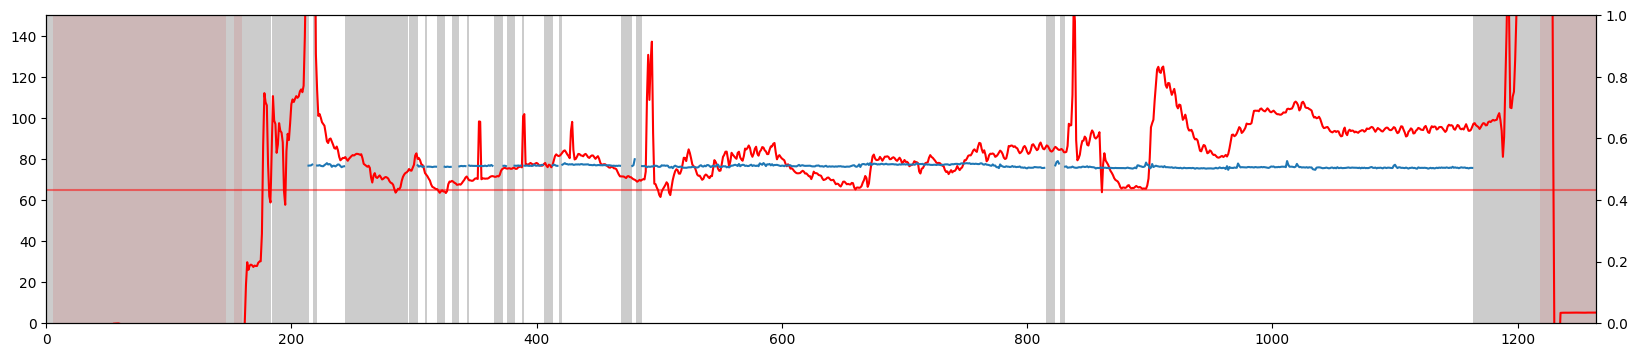

5278	0.5117260881436515	


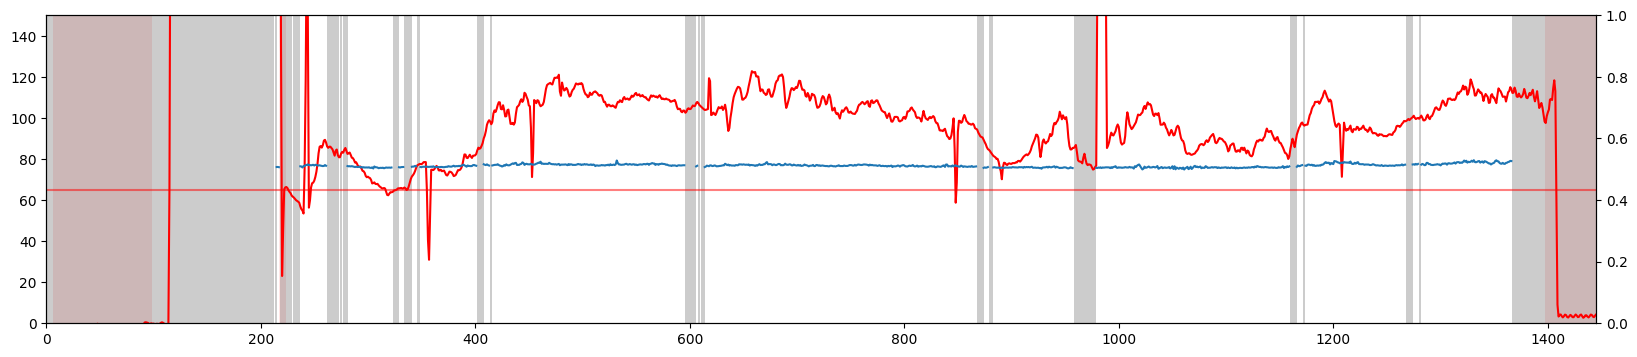

5308	0.5086406117778721	


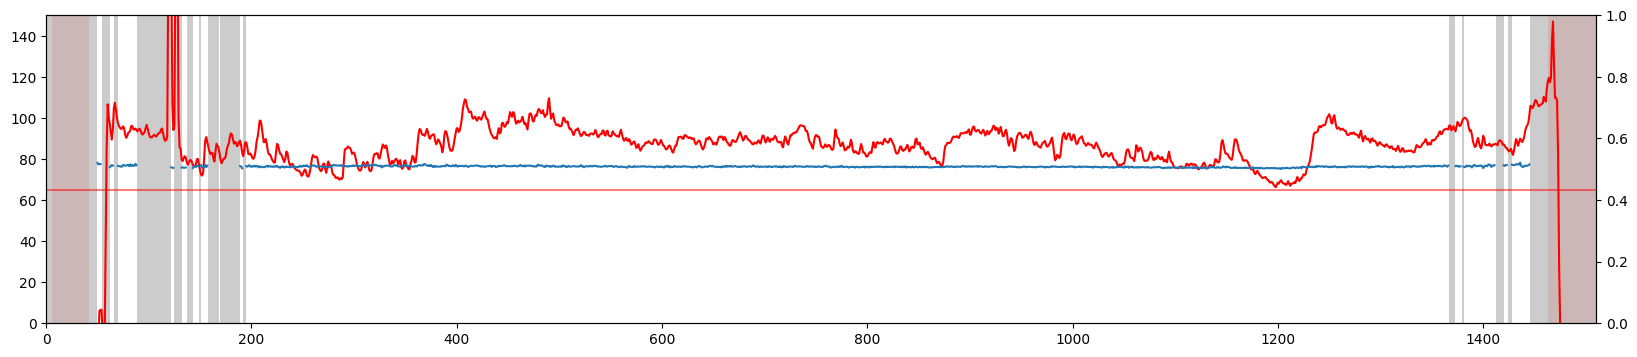

5309	0.5221148904648656	


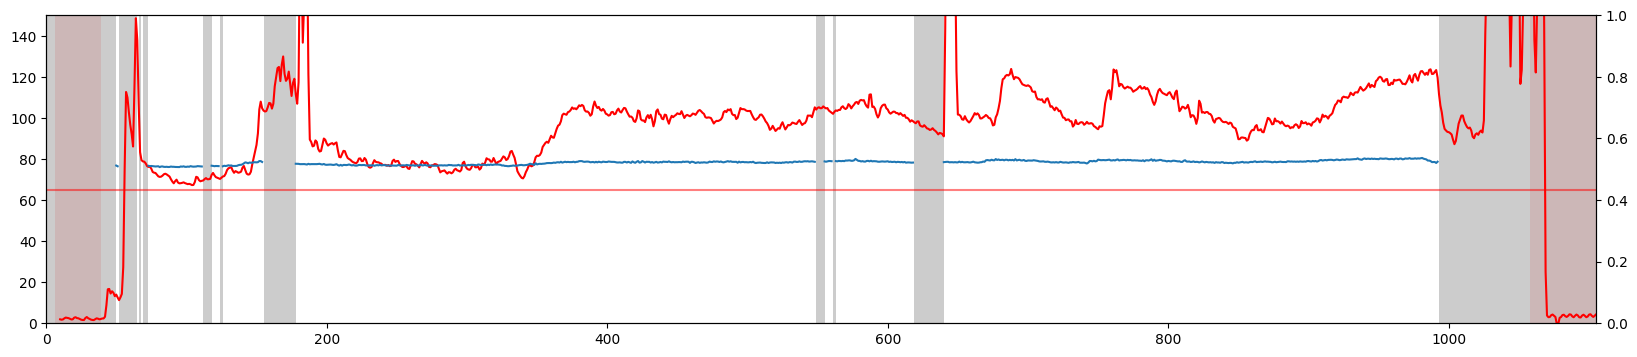

5388	0.5125031901469613	


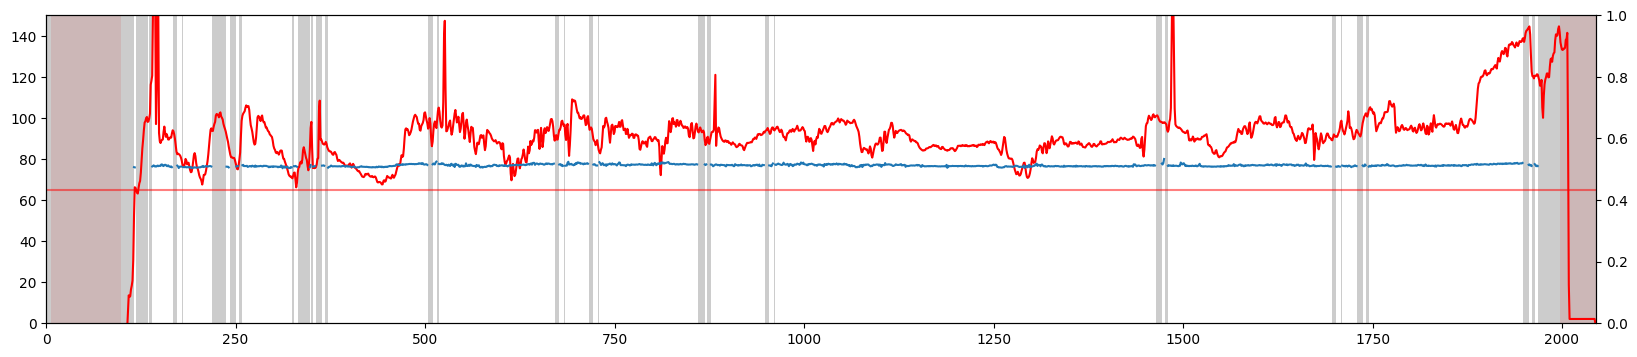

5572	0.5086351333868725	


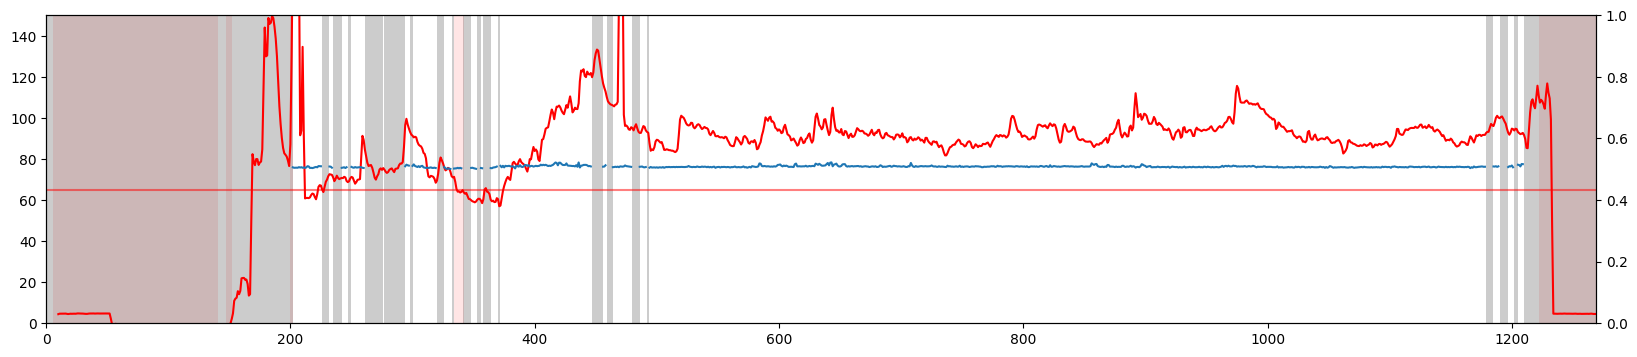

5692	0.5174845484946924	


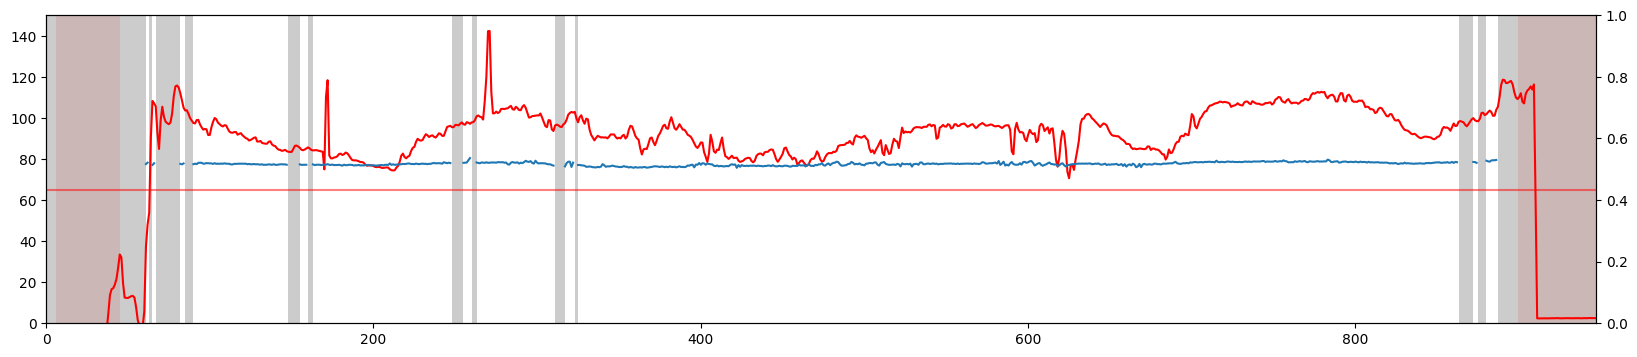

5811	0.5076082552468527	


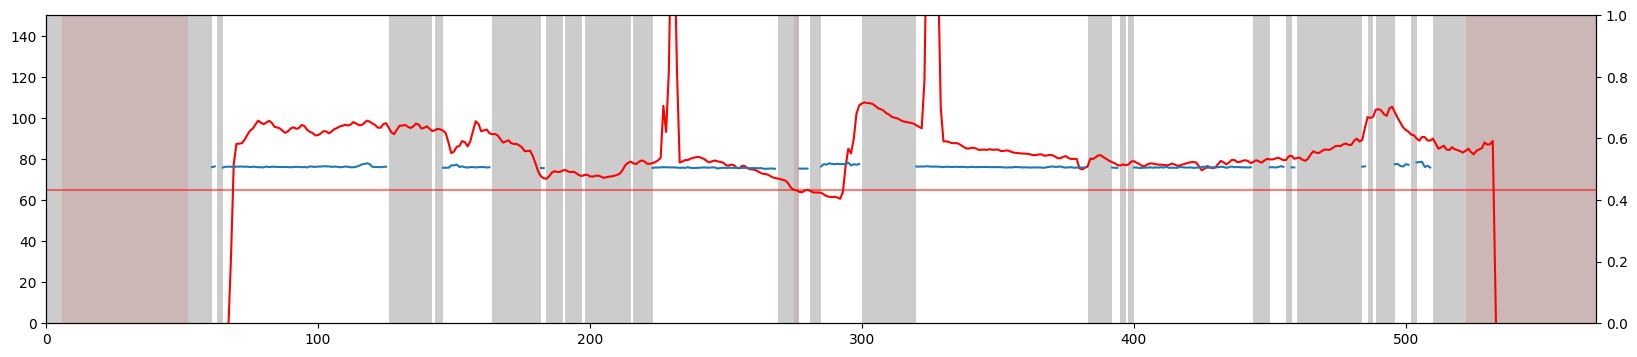

5864	0.510862172258101	


C:\Users\aaron\AppData\Local\Temp\ipykernel_36788\552489927.py:34: RuntimeWarning: Mean of empty slice
  ax1.plot(t + 10, np.nanmean(test_x[case_mask], axis=1) * 65 + 65, color='r')


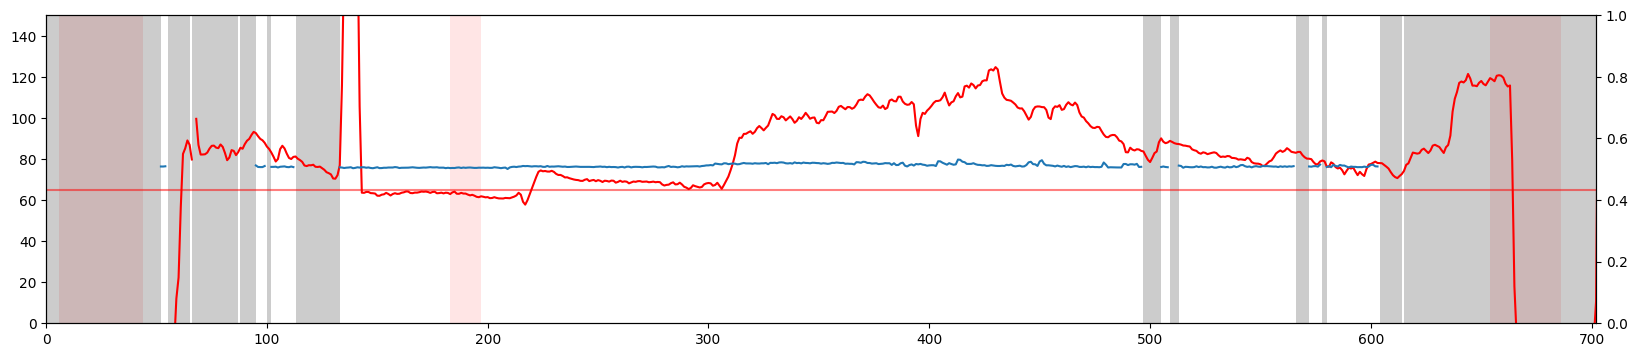

5918	0.5086593023148711	


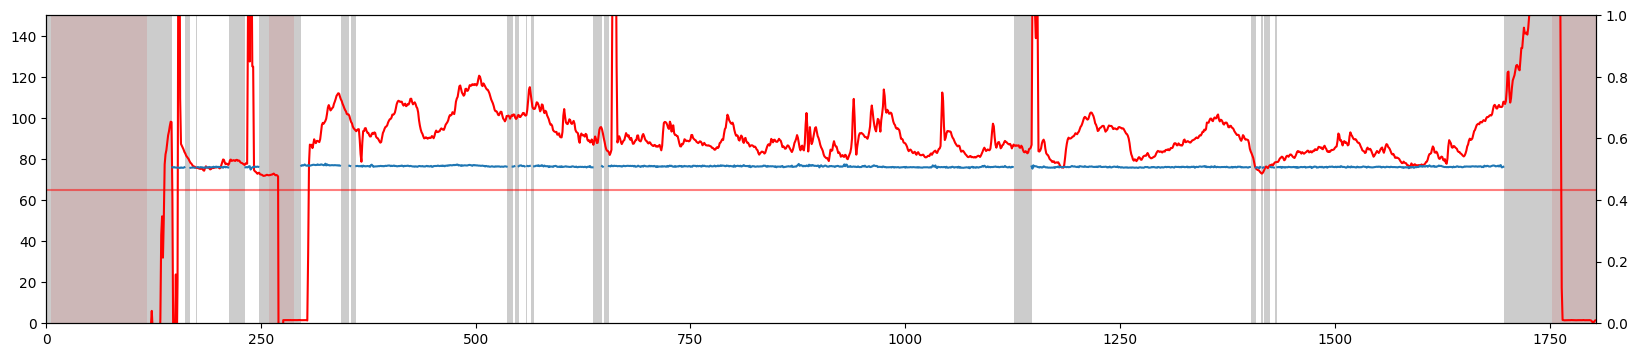

5950	0.5056524847833581	


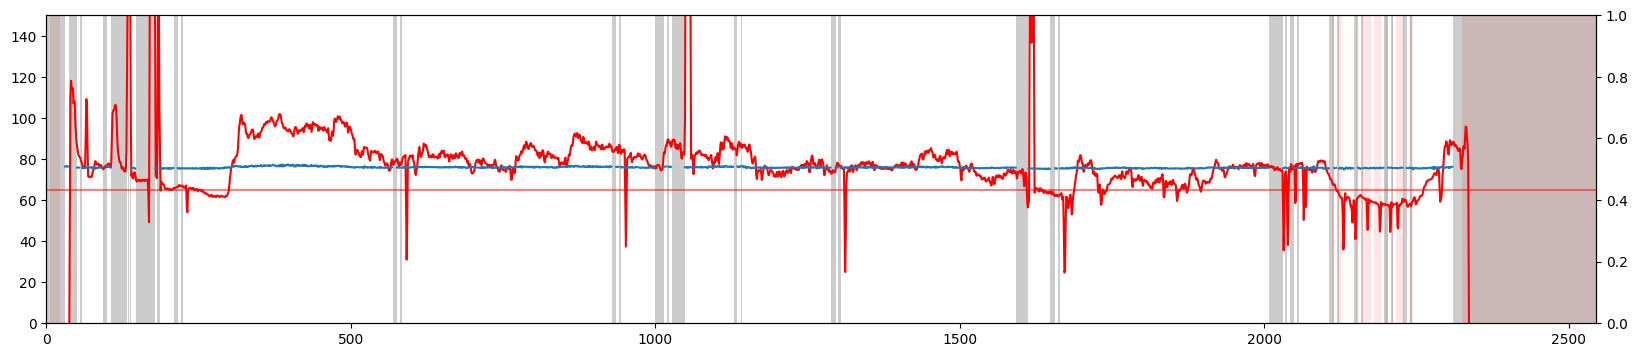

5987	0.502364172156992	


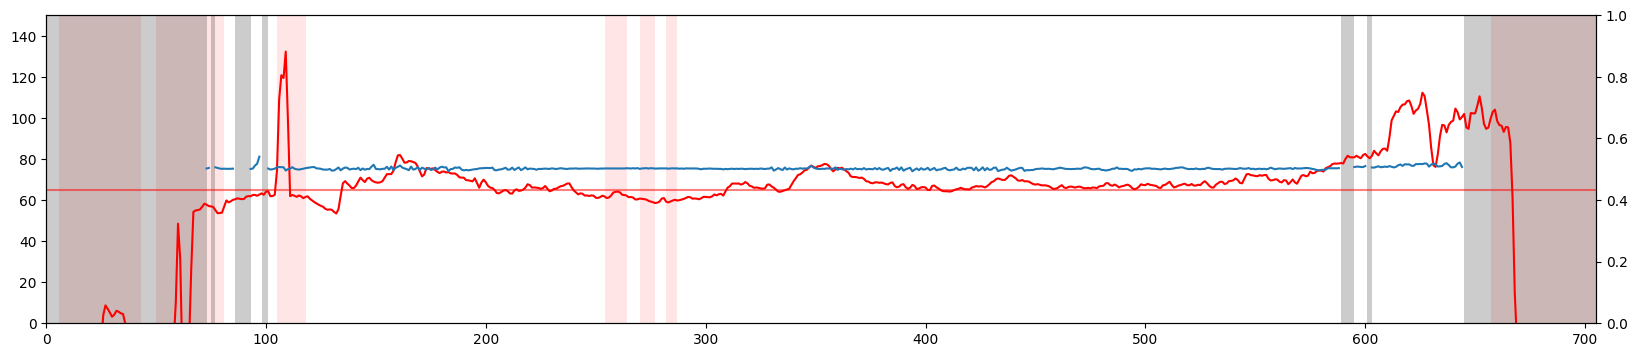

6000	0.5091899090887027	


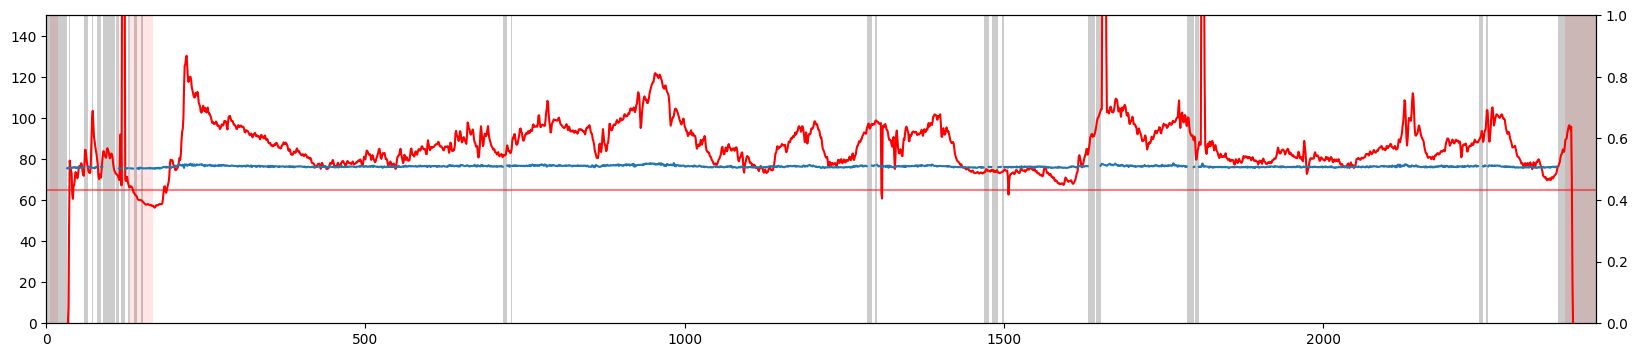

6065	0.5149212861321795	


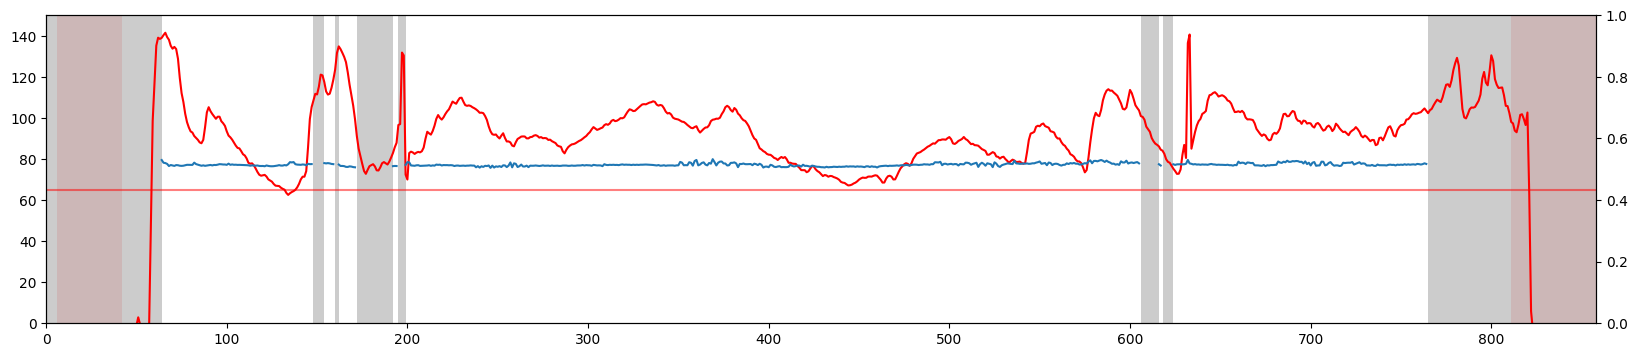

6067	0.5046998804894585	


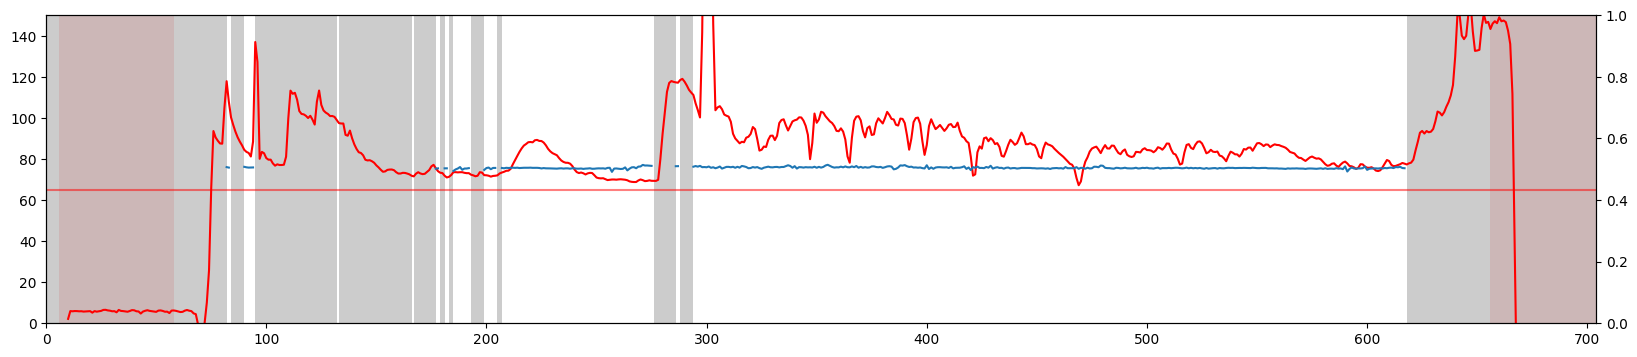

6082	0.5053906128288217	


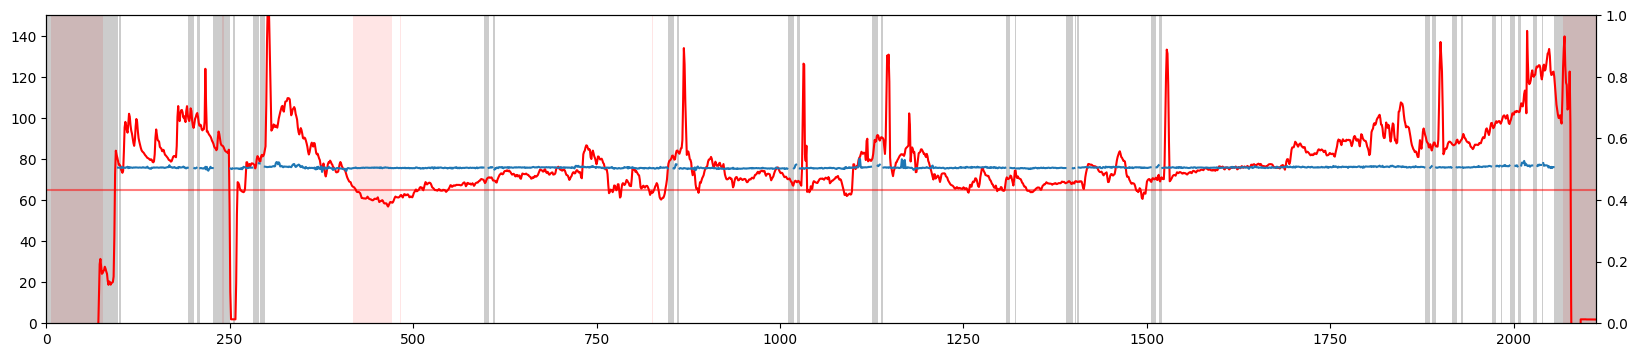

6156	0.5116430619735568	


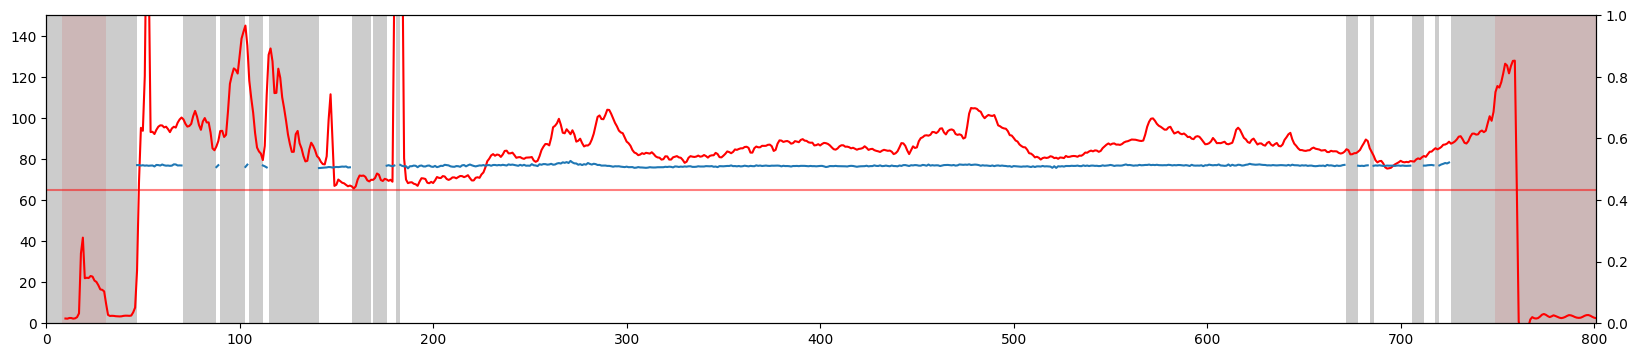

6195	0.5102669600135709	


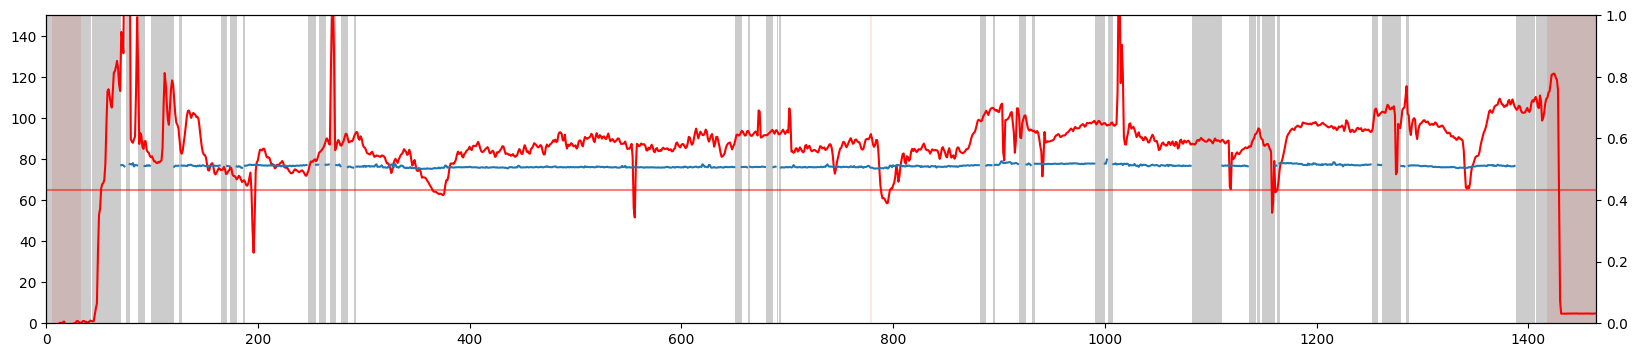

6262	0.5051095479231582	


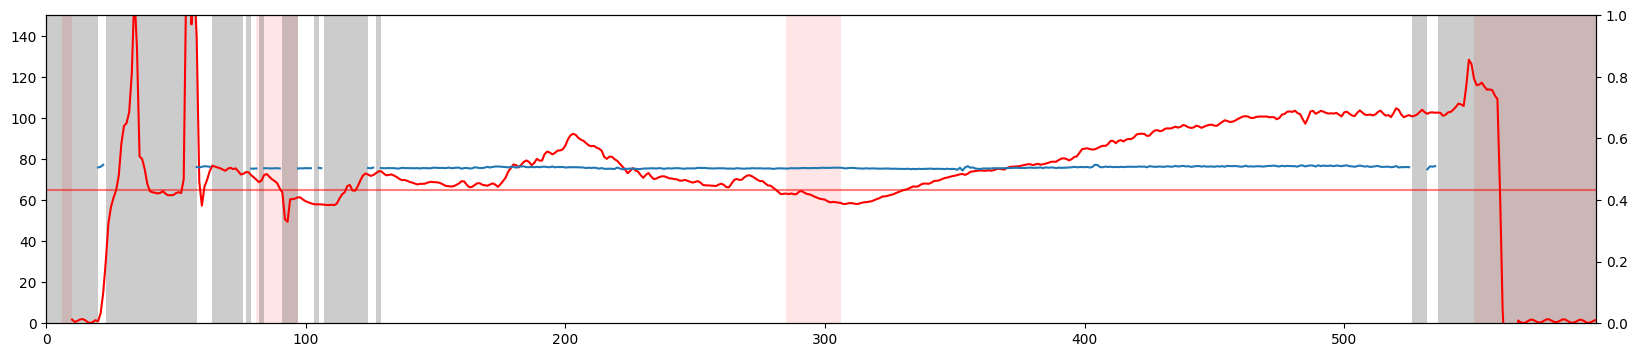

6351	0.5057825744536143	


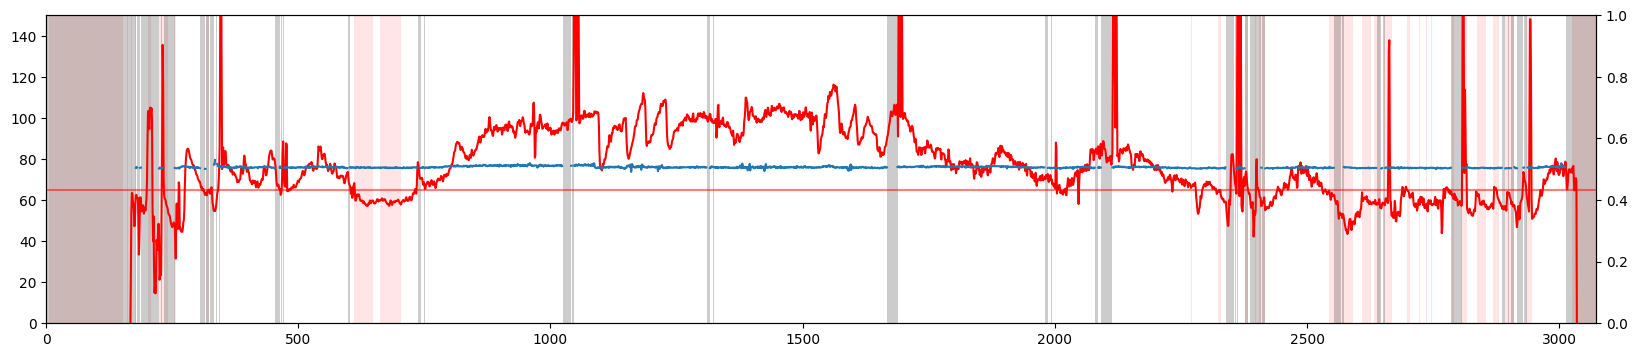

In [ ]:
for caseid in caseids_test:
    case_mask = (c[test_mask] == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = test_x[case_mask]
    case_y = test_y[case_mask]
    case_p = test_p[case_mask]
    case_valid_mask = valid_mask[test_mask][case_mask]
    case_p[~case_valid_mask] = np.nan
    if sum(case_valid_mask) == 0:
        continue
    
    # calculate error for this case
    case_rmse = np.nanmean(np.square(case_y - case_p)) ** 0.5
    print('{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 6, i + MINUTES_AHEAD * 6 + 1, color='r', alpha=0.1, lw=0)
        if not case_valid_mask[i]:
            ax1.axvspan(i, i + 1, color='k', alpha=0.2, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, np.nanmean(test_x[case_mask], axis=1) * 65 + 65, color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples only
    ax2.plot(t, case_p)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()